In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
# Vestas Power Curve
P = [0,40,100,370,650,895,1150,1500,1850,2375,2900,3525,4150,4875,5600,6350,7100,7580,7800,7920,8000] # kW
v = np.arange(3,13.5,0.5) # m/s
f = interpolate.interp1d(v, P, 'cubic', fill_value = 'extrapolate')

def singlepc(v):
    v = abs(v)
    return 0.*(v<=3) + f(v)*(v>3)*(v<=13) + 8000.*(v>13)*(v<=25) + 0.*(v>25)

def gaussian(v,v0):
    # experiment
    sigma = 1.5*(v0<=5) + 0.3*v0*(v0>5)*(v0<=10) + 3.*(v0>10)
    return np.exp(-0.5*((v-v0)/sigma)**2)/sigma/np.sqrt(2*np.pi)

def multipc(v0):
    return integrate.quad_vec(lambda v: singlepc(v)*gaussian(v,v0), -np.inf, np.inf)[0]

In [3]:
wind_ninja = pd.read_csv('data/wind/ninja_wind_56.4000_6.8000_corrected.csv',
                         sep = ',',
                         index_col = 0,
                         usecols = [0,2,3],
                         comment = '#')
v = wind_ninja['wind_speed'].values/wind_ninja['wind_speed'].mean()*10.63 # m/s global wind atlas
P = multipc(v)
cf_wind = P/8000
cf_wind.mean()

0.6312609410612152

In [4]:
pd.Series(cf_wind).to_csv('data/cf/wind.csv')

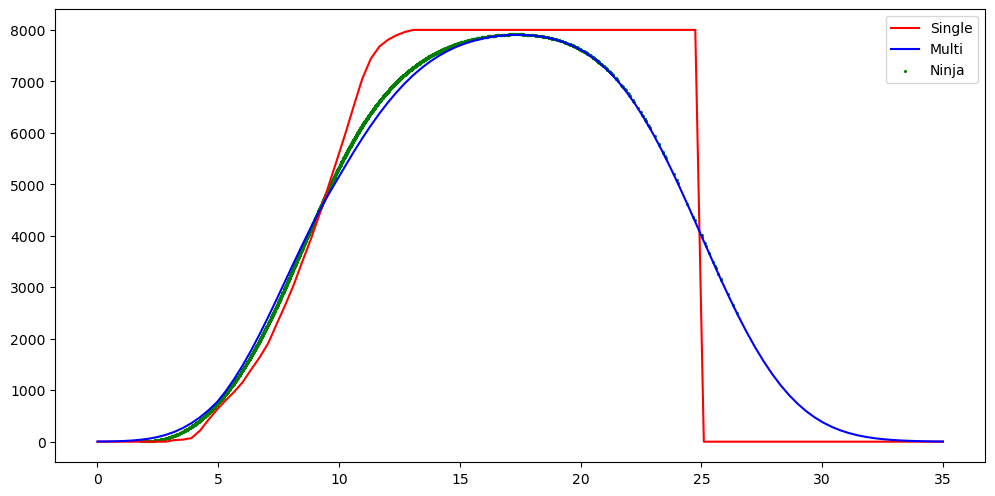

In [5]:
x = np.linspace(0,35,100)
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(x, singlepc(x), c = 'r', label = 'Single')
plt.plot(x, multipc(x), c = 'b', label = 'Multi')
plt.scatter(wind_ninja['wind_speed'], wind_ninja['electricity'], s = 1.5, c = 'g', label = 'Ninja')
plt.legend()
plt.show()